#

In [0]:
#install google spread && PyDrive
!pip install --upgrade -q gspread PyDrive
!pip install pygeocoder
!pip install geopandas
!pip install descartes

  Stored in directory: /root/.cache/pip/wheels/7c/4c/00/d05c66c4af5411c554c91b8079732c8a0359c2226fb8c01031
Successfully built pygeocoder
    100% |████████████████████████████████| 931kB 26.8MB/s 
    100% |████████████████████████████████| 10.8MB 4.2MB/s 
    100% |████████████████████████████████| 17.9MB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
import math
import os
import string
from datetime import datetime
import re
import json
import csv
import pickle
import requests
import collections
from pprint import pformat
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing.label import LabelEncoder
import tensorflow as tf
# from pygeocoder import Geocoder
from shapely.geometry import Point
import geopandas

In [0]:
# Imports
# Numpy,Pandas
import numpy as np
import pandas as pd
import datetime

# matplotlib,seaborn,pyecharts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# plt.style.use('ggplot')  #风格设置近似R这种的ggplot库
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import missingno as msno

# import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


#  忽略弹出的warnings
import warnings
warnings.filterwarnings('ignore')  

pd.set_option('display.float_format', lambda x: '%.4f' % x)

from imblearn.over_sampling import SMOTE
import itertools

In [0]:
#Goole Drive libs configuration
from oauth2client.client import GoogleCredentials
from google.colab import auth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import gspread
#@title Authenticate Google Drive client && create local directory
auth.authenticate_user()
credential = GoogleCredentials.get_application_default()
#iniate Google Spread Sheet
gc = gspread.authorize(credential)
#iniate Google Drive
gauth = GoogleAuth()
gauth.credentials = credential
drive = GoogleDrive(gauth)

# #2. Get the file
# downloaded = drive.CreateFile({'id':'1BH-rffqv_1auzO7tdubfaOwXzf278vJK'}) # replace the id with id of file you want to access
# downloaded.GetContentFile('xyz.csv') 

#Import file from Google Drive
def importfile(file_id='1W_SHJkvrYSCLXitec33iy7-MKG854ZnF'):
    f = drive.CreateFile({'id': file_id})
    print('Drive file (title: %s, id: %s)' % (f['title'], f['id']))
    fname = os.path.join(os.getcwd(), f['title'])
    print('file path: {}'.format(fname))
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
    return fname

def exportfile(file_name="sample.txt"):
    uploaded = drive.CreateFile({'title':file_name})
    uploaded.Upload()
    print('file {} uploaded to Google Drive'.format(file_name))
    
def create_dir(dir_name="Sample"):
  dir_path=os.path.join(os.getcwd(),dir_name)
  if not os.path.exists(dir_path):
    os.makedirs(dir_name)
  return dir_path


CWD=os.getcwd()
print("Current root dir: ",CWD)

# oracle = importfile(file_id = '1LdDacl36PS9cp_dDENFRB5gny5Hd_Wo9')
# novehicle = importfile(file_id = '1YLMTcSqbxD67t125dx5ZmvJayb8IR1rA')

Current root dir:  /content
Drive file (title: metadata.csv, id: 1LdDacl36PS9cp_dDENFRB5gny5Hd_Wo9)
file path: /content/metadata.csv
Drive file (title: novehicle.csv, id: 1YLMTcSqbxD67t125dx5ZmvJayb8IR1rA)
file path: /content/novehicle.csv


In [0]:
!ls

adc.json  metadata.csv	novehicle.csv  sample_data  timeseries.csv


## Merge vehicle and novehicle datasets

In [0]:
novehicle = pd.read_csv(os.path.join("/content","novehicle.csv"), header = 0, keep_default_na = False)
vehicle = pd.read_csv(os.path.join("/content","metadata.csv"), header = 0, keep_default_na = False)
vehicle['label'] = '1'
novehicle['label'] = '0'
vehicle = vehicle.dropna(how = 'any', axis = 0)
novehicle = novehicle.dropna(how = 'any', axis = 0)

In [0]:
# vehicle.replace('', 'unknown_1', inplace = True)
# vehicle.fillna('unknown_1', inplace = True)
vehicle.vehicle_type.unique()

array(['Nissan Leaf', 'Chevrolet Volt', 'Mitsubishi i-MiEV', '',
       'Tesla Model S'], dtype=object)

In [0]:
index = []
for i in range(novehicle.shape[0]):
  if novehicle.iloc[i ,0] in [483,  503,  516,  744,  781,  821,  871,  946, 1086, 1103, 1283, 1463, 1632, 1700, 1796, 2004, 2094, 2129, 2158, 2204, 2337, 2557,
       2575, 2818, 3009, 3039, 3134, 3221, 3310, 3394, 3413, 3456, 3506,3736,4031, 4193,4297,4313,4473,
       3649, 3719]:
    index.append(i)

novehicle = novehicle.iloc[index,]

In [0]:
novehicle.head(5)

dataid               localhour car1 any_electric_vehicle    status  \
0     483  2017-01-02 04:00:00-06                        No  Complete   
1     483  2017-03-13 20:00:00-05                        No  Complete   
2     483  2017-03-16 01:00:00-05                        No  Complete   
3     483  2017-04-04 07:00:00-05                        No  Complete   
4     483  2017-04-14 23:00:00-05                        No  Complete   

  spend_time_at_home_monday spend_time_at_home_tuesday  \
0                    Monday                    Tuesday   
1                    Monday                    Tuesday   
2                    Monday                    Tuesday   
3                    Monday                    Tuesday   
4                    Monday                    Tuesday   

  spend_time_at_home_wednesday spend_time_at_home_thursday  \
0                    Wednesday                    Thursday   
1                    Wednesday                    Thursday   
2                    Wednesday                    Thursday   
3                    Wednesday                    Thursday   
4                    Wednesday                    Thursday   

  spend_time_at_home_friday  ...  electric_vehicle_buy_reason_envir  \
0                    Friday  ...                                      
1                    Friday  ...                                      
2                    Friday  ...                                      
3                    Friday  ...                                      
4                    Friday  ...                                      

  electric_vehicle_buy_reason_save_money  \
0                                          
1                                          
2                                          
3                                          
4                                          

  electric_vehicle_buy_reason_new_tech_interest  \
0                                                 
1                                                 
2                                                 
3                                                 
4                                                 

  electric_vehicle_buy_reason_performance  \
0                                           
1                                           
2                                           
3                                           
4                                           

  electric_vehicle_buy_reason_quietness  \
0                                         
1                                         
2                                         
3                                         
4                                         

  electric_vehicle_buy_reason_other_recommended electric_vehicle_buy_again  \
0                                                                       No   
1                                                                       No   
2                                                                       No   
3                                                                       No   
4                                                                       No   

     city  state label  
0  Austin  Texas     0  
1  Austin  Texas     0  
2  Austin  Texas     0  
3  Austin  Texas     0  
4  Austin  Texas     0  

[5 rows x 36 columns]

In [0]:
idx = 1
new_col = np.nan  
for j in ['ownership_status','delivery_date','quick_charge_port','model_year','vehicle_type']:
  novehicle.insert(loc=idx, column=j, value=new_col)
novehicle.replace('', 'unknown_0', inplace = True)
novehicle.fillna('unknown_0', inplace = True)
novehicle.groupby('spend_time_at_home_monday').size()

spend_time_at_home_monday
Monday       207222
unknown_0    123410
dtype: int64

In [0]:
novehicle.spend_time_at_home_monday.unique()

array(['Monday', 'unknown_0'], dtype=object)

In [0]:
capstone = vehicle.append(novehicle, ignore_index = True)

In [0]:
from google.colab import drive
drive.mount('drive')

capstone.to_csv('capstone.csv')
!cp capstone.csv drive/My\ Drive/

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Capstone dataset

In [0]:
Capstone = importfile(file_id = '1-1lVd9sPctCOOrpxJ8vpf7qf6zhU3EhN')
Capstone = pd.read_csv(os.path.join("/content","capstone.csv"), header = 0, keep_default_na = False)

Drive file (title: capstone.csv, id: 1-1lVd9sPctCOOrpxJ8vpf7qf6zhU3EhN)
file path: /content/capstone.csv


In [0]:
Capstone.any_electric_vehicle.value_counts()

No           363162
Yes          289043
unknown_1     11397
Name: any_electric_vehicle, dtype: int64

## Delete the useless features

In [0]:
for feature in ['Unnamed: 0', 'delivery_date', 'status']:
  Capstone.drop(feature ,axis = 1, inplace = True)

## Feature Engineering

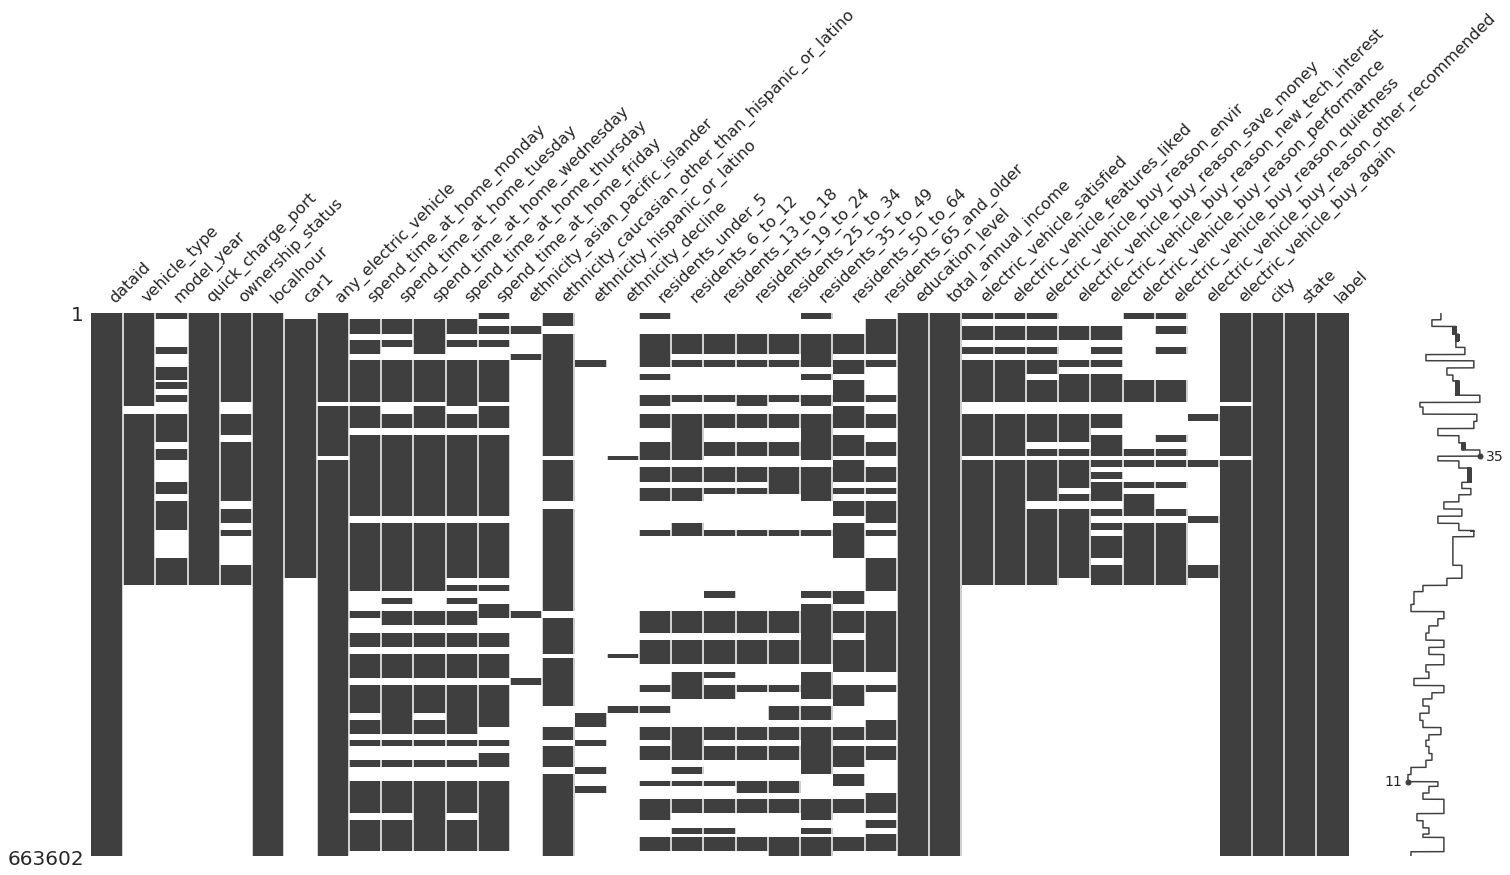

In [0]:
# see missing values
missing_map = Capstone.replace(['unknown_0','unknown_1'],np.nan)
msno.matrix(missing_map)

In [0]:
Capstone.columns

Index(['dataid', 'vehicle_type', 'model_year', 'quick_charge_port',
       'ownership_status', 'localhour', 'car1', 'any_electric_vehicle',
       'spend_time_at_home_monday', 'spend_time_at_home_tuesday',
       'spend_time_at_home_wednesday', 'spend_time_at_home_thursday',
       'spend_time_at_home_friday', 'ethnicity_asian_pacific_islander',
       'ethnicity_caucasian_other_than_hispanic_or_latino',
       'ethnicity_hispanic_or_latino', 'ethnicity_decline',
       'residents_under_5', 'residents_6_to_12', 'residents_13_to_18',
       'residents_19_to_24', 'residents_25_to_34', 'residents_35_to_49',
       'residents_50_to_64', 'residents_65_and_older', 'education_level',
       'total_annual_income', 'electric_vehicle_satisfied',
       'electric_vehicle_features_liked', 'electric_vehicle_buy_reason_envir',
       'electric_vehicle_buy_reason_save_money',
       'electric_vehicle_buy_reason_new_tech_interest',
       'electric_vehicle_buy_reason_performance',
       'electric_veh

### Vehicle_type & Model_year

In [0]:
Capstone.head()

dataid vehicle_type model_year quick_charge_port       ownership_status  \
0     410  Nissan Leaf       2016             False  Leased by Participant   
1     410  Nissan Leaf       2016             False  Leased by Participant   
2     410  Nissan Leaf       2016             False  Leased by Participant   
3     410  Nissan Leaf       2016             False  Leased by Participant   
4     410  Nissan Leaf       2016             False  Leased by Participant   

       localhour       car1 any_electric_vehicle spend_time_at_home_monday  \
0  1/29/17 11:00  unknown_1                  Yes                 unknown_1   
1  4/20/17 13:00  unknown_1                  Yes                 unknown_1   
2   5/7/17 12:00  unknown_1                  Yes                 unknown_1   
3   5/7/17 13:00  unknown_1                  Yes                 unknown_1   
4  5/10/17 11:00  unknown_1                  Yes                 unknown_1   

  spend_time_at_home_tuesday  ...  electric_vehicle_buy_reason_envir  \
0                  unknown_1  ...              Environmental benefit   
1                  unknown_1  ...              Environmental benefit   
2                  unknown_1  ...              Environmental benefit   
3                  unknown_1  ...              Environmental benefit   
4                  unknown_1  ...              Environmental benefit   

  electric_vehicle_buy_reason_save_money  \
0                              unknown_1   
1                              unknown_1   
2                              unknown_1   
3                              unknown_1   
4                              unknown_1   

  electric_vehicle_buy_reason_new_tech_interest  \
0                                     unknown_1   
1                                     unknown_1   
2                                     unknown_1   
3                                     unknown_1   
4                                     unknown_1   

  electric_vehicle_buy_reason_performance  \
0  Acceleration and performance of EVâ€™s   
1  Acceleration and performance of EVâ€™s   
2  Acceleration and performance of EVâ€™s   
3  Acceleration and performance of EVâ€™s   
4  Acceleration and performance of EVâ€™s   

  electric_vehicle_buy_reason_quietness  \
0                             Quietness   
1                             Quietness   
2                             Quietness   
3                             Quietness   
4                             Quietness   

  electric_vehicle_buy_reason_other_recommended electric_vehicle_buy_again  \
0                                     unknown_1                         No   
1                                     unknown_1                         No   
2                                     unknown_1                         No   
3                                     unknown_1                         No   
4                                     unknown_1                         No   

     city  state label  
0  Austin  Texas     1  
1  Austin  Texas     1  
2  Austin  Texas     1  
3  Austin  Texas     1  
4  Austin  Texas     1  

[5 rows x 39 columns]

In [0]:
Capstone.groupby('model_year').size()

model_year
2011           6471
2012          23933
2013          12600
2014           2706
2015           3442
2008           8732
2011          24602
2012          42766
2013          29509
2014          13615
2015           5290
2016           8727
unknown_0    330632
unknown_1    150577
dtype: int64

### Quick_charge_port & ownership statues & car2 & any_electric_vehicle

In [0]:
Capstone.quick_charge_port = Capstone.quick_charge_port.astype('str')
Capstone.quick_charge_port.unique()

array(['False', 'True', 'unknown_0'], dtype=object)

In [0]:
Capstone.ownership_status.unique()

array(['Leased by Participant', 'Owned by Participant', 'unknown_1',
       'unknown_0'], dtype=object)

In [0]:
Capstone.insert(loc=7, column='car2', value=Capstone.car1)

In [0]:
Capstone.head(5)

dataid vehicle_type model_year quick_charge_port       ownership_status  \
0     410  Nissan Leaf       2016             False  Leased by Participant   
1     410  Nissan Leaf       2016             False  Leased by Participant   
2     410  Nissan Leaf       2016             False  Leased by Participant   
3     410  Nissan Leaf       2016             False  Leased by Participant   
4     410  Nissan Leaf       2016             False  Leased by Participant   

       localhour       car1       car2 any_electric_vehicle  \
0  1/29/17 11:00  unknown_1  unknown_1                  Yes   
1  4/20/17 13:00  unknown_1  unknown_1                  Yes   
2   5/7/17 12:00  unknown_1  unknown_1                  Yes   
3   5/7/17 13:00  unknown_1  unknown_1                  Yes   
4  5/10/17 11:00  unknown_1  unknown_1                  Yes   

  spend_time_at_home_monday  ...  electric_vehicle_buy_reason_envir  \
0                 unknown_1  ...              Environmental benefit   
1                 unknown_1  ...              Environmental benefit   
2                 unknown_1  ...              Environmental benefit   
3                 unknown_1  ...              Environmental benefit   
4                 unknown_1  ...              Environmental benefit   

  electric_vehicle_buy_reason_save_money  \
0                              unknown_1   
1                              unknown_1   
2                              unknown_1   
3                              unknown_1   
4                              unknown_1   

  electric_vehicle_buy_reason_new_tech_interest  \
0                                     unknown_1   
1                                     unknown_1   
2                                     unknown_1   
3                                     unknown_1   
4                                     unknown_1   

  electric_vehicle_buy_reason_performance  \
0  Acceleration and performance of EVâ€™s   
1  Acceleration and performance of EVâ€™s   
2  Acceleration and performance of EVâ€™s   
3  Acceleration and performance of EVâ€™s   
4  Acceleration and performance of EVâ€™s   

  electric_vehicle_buy_reason_quietness  \
0                             Quietness   
1                             Quietness   
2                             Quietness   
3                             Quietness   
4                             Quietness   

  electric_vehicle_buy_reason_other_recommended electric_vehicle_buy_again  \
0                                     unknown_1                         No   
1                                     unknown_1                         No   
2                                     unknown_1                         No   
3                                     unknown_1                         No   
4                                     unknown_1                         No   

     city  state label  
0  Austin  Texas     1  
1  Austin  Texas     1  
2  Austin  Texas     1  
3  Austin  Texas     1  
4  Austin  Texas     1  

[5 rows x 40 columns]

In [0]:
Capstone.car2.unique()

array(['unknown_1', '0', '0.001433333', ..., '1.631133333', '0.005903226',
       'unknown_0'], dtype=object)

In [0]:
Capstone.car2 = Capstone.car2.replace(['unknown_0', 'unknown_1'], '0.0')
Capstone.car2 = Capstone.car2.astype(float)
Capstone['car2'][Capstone['car2']>0] = 1
Capstone.car2 = Capstone.car2.astype(int)
Capstone.car2.unique()

array([0, 1])

In [0]:
Capstone.any_electric_vehicle.value_counts()

No           363162
Yes          289043
unknown_1     11397
Name: any_electric_vehicle, dtype: int64

### Spend_time_at_home

In [0]:
[Capstone[i].value_counts() for i in Capstone.iloc[:,9:14]]

[Monday       492000
 unknown_0    123410
 unknown_1     48192
 Name: spend_time_at_home_monday, dtype: int64, Tuesday      498922
 unknown_0     99024
 unknown_1     65656
 Name: spend_time_at_home_tuesday, dtype: int64, Wednesday    518196
 unknown_0    105946
 unknown_1     39460
 Name: spend_time_at_home_wednesday, dtype: int64, Thursday     495876
 unknown_0     99024
 unknown_1     68702
 Name: spend_time_at_home_thursday, dtype: int64, Friday       500731
 unknown_0     97835
 unknown_1     65036
 Name: spend_time_at_home_friday, dtype: int64]

### Ethnicity

In [0]:
[Capstone[i].value_counts() for i in Capstone.iloc[:,14:18]]

[unknown_1                 316653
 unknown_0                 313168
 Asian/Pacific Islander     33781
 Name: ethnicity_asian_pacific_islander, dtype: int64, Caucasian    584239
 unknown_0     56188
 unknown_1     23175
 Name: ethnicity_caucasian_other_than_hispanic_or_latino, dtype: int64, unknown_1    324238
 unknown_0    288756
 Hispanic      50608
 Name: ethnicity_hispanic_or_latino, dtype: int64, unknown_1             327259
 unknown_0             316948
 Decline to Respond     19395
 Name: ethnicity_decline, dtype: int64]

### Age

In [0]:
for i in Capstone.iloc[:,18:26]:
  Capstone[i] = Capstone[i].astype(str)
[Capstone[i].value_counts() for i in Capstone.iloc[:,18:26]]

[0            204342
 unknown_1    179899
 unknown_0    175241
 1             58098
 2             46022
 Name: residents_under_5, dtype: int64, 0            201674
 unknown_1    182882
 unknown_0    144580
 2             65783
 1             47410
 3             21273
 Name: residents_6_to_12, dtype: int64, 0            231055
 unknown_1    223521
 unknown_0    160888
 1             39406
 2              8732
 Name: residents_13_to_18, dtype: int64, 0            222326
 unknown_1    217835
 unknown_0    184601
 1             30108
 2              8732
 Name: residents_19_to_24, dtype: int64, unknown_1    215967
 0            215467
 unknown_0    161581
 1             62483
 2              8104
 Name: residents_25_to_34, dtype: int64, 2            165910
 unknown_1    154881
 1            148788
 0            110410
 unknown_0     83613
 Name: residents_35_to_49, dtype: int64, 0            207361
 unknown_0    134541
 unknown_1    118737
 2            108687
 1             94276
 Name:

### Education_level & total_income

In [0]:
[Capstone[i].value_counts() for i in Capstone.iloc[:,26:28]]

[Postgraduate degree                     485552
 College graduate                        169320
 Some college/trade/vocational school      8730
 Name: education_level, dtype: int64, $100,000 - $149,999      246006
 $150,000 - $299,000      179796
 $75,000 - $99,999         94282
 $50,000 - $74,999         91761
 $300,000 - $1,000,000     43025
 $20,000 - $34,999          8732
 Name: total_annual_income, dtype: int64]

### electric_vehicle_question

In [0]:
Capstone.electric_vehicle_buy_reason_performance = Capstone.electric_vehicle_buy_reason_performance.replace('Acceleration and performance of EVâ€™s', 
                                                                                                            'Acceleration and performance')
[Capstone[i].value_counts() for i in Capstone.iloc[:,28:37]]

[unknown_0             330632
 Very satisfied        263990
 unknown_1              43927
 Neutral                16321
 Somewhat satisfied      8732
 Name: electric_vehicle_satisfied, dtype: int64,
 unknown_0                              330632
 Environmental and societal benefits    119955
 Power, speed, performance              119425
 unknown_1                               43927
 Not buying gasoline                     42482
 Quiet                                    7181
 Name: electric_vehicle_features_liked, dtype: int64,
 unknown_0                330632
 Environmental benefit    264407
 unknown_1                 68563
 Name: electric_vehicle_buy_reason_envir, dtype: int64,
 unknown_0                   330632
 Saving money on gasoline    229076
 unknown_1                   103894
 Name: electric_vehicle_buy_reason_save_money, dtype: int64,
 unknown_0                       330632
 Interest in new technologies    220340
 unknown_1                       112630
 Name: electric_vehic

### City & State & Label

In [0]:
[Capstone[i].value_counts() for i in Capstone.iloc[:,37:40]]

[Austin        572379
 Plano          26196
 Boulder        15654
 Houston        14445
 Round Rock      8732
 Dallas          8732
 Coppell         8732
 Humble          8732
 Name: city, dtype: int64, Texas       647948
 Colorado     15654
 Name: state, dtype: int64, 1    332970
 0    330632
 Name: label, dtype: int64]

## One-Hot encoding with all features

### Step 1:

In [0]:
for i in ['vehicle_type', 'model_year', 'quick_charge_port']:
  Capstone = pd.concat([Capstone,pd.get_dummies(Capstone[i], prefix=i)],axis=1)
  Capstone.drop([i],axis=1, inplace=True)


In [0]:
Capstone.head()

dataid       ownership_status      localhour       car1  car2  \
0     410  Leased by Participant  1/29/17 11:00  unknown_1     0   
1     410  Leased by Participant  4/20/17 13:00  unknown_1     0   
2     410  Leased by Participant   5/7/17 12:00  unknown_1     0   
3     410  Leased by Participant   5/7/17 13:00  unknown_1     0   
4     410  Leased by Participant  5/10/17 11:00  unknown_1     0   

  any_electric_vehicle spend_time_at_home_monday spend_time_at_home_tuesday  \
0                  Yes                 unknown_1                  unknown_1   
1                  Yes                 unknown_1                  unknown_1   
2                  Yes                 unknown_1                  unknown_1   
3                  Yes                 unknown_1                  unknown_1   
4                  Yes                 unknown_1                  unknown_1   

  spend_time_at_home_wednesday spend_time_at_home_thursday  \
0                    unknown_1                   unknown_1   
1                    unknown_1                   unknown_1   
2                    unknown_1                   unknown_1   
3                    unknown_1                   unknown_1   
4                    unknown_1                   unknown_1   

              ...             model_year_2012 model_year_2013 model_year_2014  \
0             ...                           0               0               0   
1             ...                           0               0               0   
2             ...                           0               0               0   
3             ...                           0               0               0   
4             ...                           0               0               0   

  model_year_2015 model_year_2016 model_year_unknown_0 model_year_unknown_1  \
0               0               1                    0                    0   
1               0               1                    0                    0   
2               0               1                    0                    0   
3               0               1                    0                    0   
4               0               1                    0                    0   

  quick_charge_port_False quick_charge_port_True quick_charge_port_unknown_0  
0                       1                      0                           0  
1                       1                      0                           0  
2                       1                      0                           0  
3                       1                      0                           0  
4                       1                      0                           0  

[5 rows x 60 columns]

### Step 2:

In [0]:
for i in ['ownership_status', 'car2', 'any_electric_vehicle', 'ethnicity_asian_pacific_islander']:
  Capstone = pd.concat([Capstone,pd.get_dummies(Capstone[i], prefix=i)],axis=1)
  Capstone.drop([i],axis=1, inplace=True)

In [0]:
for i in ['spend_time_at_home_monday', 'spend_time_at_home_tuesday',
       'spend_time_at_home_wednesday', 'spend_time_at_home_thursday',
       'spend_time_at_home_friday']:
  Capstone = pd.concat([Capstone,pd.get_dummies(Capstone[i], prefix=i)],axis=1)
  Capstone.drop([i],axis=1, inplace=True)

In [0]:
for i in ['ethnicity_caucasian_other_than_hispanic_or_latino',
       'ethnicity_hispanic_or_latino', 'ethnicity_decline']:
  Capstone = pd.concat([Capstone,pd.get_dummies(Capstone[i], prefix=i)],axis=1)
  Capstone.drop([i],axis=1, inplace=True)

### Step 2:

In [0]:
for i in ['residents_under_5', 'residents_6_to_12', 'residents_13_to_18',
       'residents_19_to_24', 'residents_25_to_34', 'residents_35_to_49',
       'residents_50_to_64', 'residents_65_and_older', 'education_level',
       'total_annual_income', 'electric_vehicle_satisfied',
       'electric_vehicle_features_liked', 'electric_vehicle_buy_reason_envir',
       'electric_vehicle_buy_reason_save_money']:
  Capstone = pd.concat([Capstone,pd.get_dummies(Capstone[i], prefix=i)],axis=1)
  Capstone.drop([i],axis=1, inplace=True)

### Step 3:

In [0]:
for i in ['electric_vehicle_buy_reason_new_tech_interest',
       'electric_vehicle_buy_reason_performance',
       'electric_vehicle_buy_reason_quietness',
       'electric_vehicle_buy_reason_other_recommended',
       'electric_vehicle_buy_again', 'city']:
  Capstone = pd.concat([Capstone,pd.get_dummies(Capstone[i], prefix=i)],axis=1)
  Capstone.drop([i],axis=1, inplace=True)

In [0]:
Capstone.head(5)

dataid      localhour       car1  state  label  \
0     410  1/29/17 11:00  unknown_1  Texas      1   
1     410  4/20/17 13:00  unknown_1  Texas      1   
2     410   5/7/17 12:00  unknown_1  Texas      1   
3     410   5/7/17 13:00  unknown_1  Texas      1   
4     410  5/10/17 11:00  unknown_1  Texas      1   

   vehicle_type_Chevrolet Volt  vehicle_type_Mitsubishi i-MiEV  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   vehicle_type_Nissan Leaf  vehicle_type_Tesla Model S  \
0                         1                           0   
1                         1                           0   
2                         1                           0   
3                         1                           0   
4                         1                           0   

   vehicle_type_unknown_0       ...         electric_vehicle_buy_again_Yes  \
0                       0       ...                                      0   
1                       0       ...                                      0   
2                       0       ...                                      0   
3                       0       ...                                      0   
4                       0       ...                                      0   

   electric_vehicle_buy_again_unknown_1  city_Austin  city_Boulder  \
0                                     0            1             0   
1                                     0            1             0   
2                                     0            1             0   
3                                     0            1             0   
4                                     0            1             0   

   city_Coppell  city_Dallas  city_Houston  city_Humble  city_Plano  \
0             0            0             0            0           0   
1             0            0             0            0           0   
2             0            0             0            0           0   
3             0            0             0            0           0   
4             0            0             0            0           0   

   city_Round Rock  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 154 columns]

## Mount Capstone dataset to google drive

In [0]:
from google.colab import drive
drive.mount('drive')

Capstone.to_csv('4-15.csv')
!cp 4-15.csv drive/My\ Drive/

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Import rawdata and pandas read in csv

In [0]:
rawdata = importfile(file_id = '1--KuXI0DP71CpCCYzD_M4x0sT-YJkce7')
rawdata = pd.read_csv(os.path.join("/content","4-15.csv"), header = 0, encoding='latin-1', keep_default_na = False)
rawdata.drop(['Unnamed: 0'] ,axis = 1, inplace = True)
rawdata.head()

Drive file (title: 4-15.csv, id: 1--KuXI0DP71CpCCYzD_M4x0sT-YJkce7)
file path: /content/4-15.csv


dataid      localhour       car1  state  label  \
0     410  1/29/17 11:00  unknown_1  Texas      1   
1     410  4/20/17 13:00  unknown_1  Texas      1   
2     410   5/7/17 12:00  unknown_1  Texas      1   
3     410   5/7/17 13:00  unknown_1  Texas      1   
4     410  5/10/17 11:00  unknown_1  Texas      1   

   vehicle_type_Chevrolet Volt  vehicle_type_Mitsubishi i-MiEV  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   vehicle_type_Nissan Leaf  vehicle_type_Tesla Model S  \
0                         1                           0   
1                         1                           0   
2                         1                           0   
3                         1                           0   
4                         1                           0   

   vehicle_type_unknown_0       ...         electric_vehicle_buy_again_Yes  \
0                       0       ...                                      0   
1                       0       ...                                      0   
2                       0       ...                                      0   
3                       0       ...                                      0   
4                       0       ...                                      0   

   electric_vehicle_buy_again_unknown_1  city_Austin  city_Boulder  \
0                                     0            1             0   
1                                     0            1             0   
2                                     0            1             0   
3                                     0            1             0   
4                                     0            1             0   

   city_Coppell  city_Dallas  city_Houston  city_Humble  city_Plano  \
0             0            0             0            0           0   
1             0            0             0            0           0   
2             0            0             0            0           0   
3             0            0             0            0           0   
4             0            0             0            0           0   

   city_Round Rock  
0                0  
1                0  
2                0  
3                0  
4                0  

[5 rows x 154 columns]

## import use dataset and pandas read in csv

In [0]:
# use = importfile(file_id = '1_nCEVDclSvxDHGyM5FVK8wZblpVw_3iV')
use = pd.read_csv(os.path.join("/content","use.csv"), header = 0, keep_default_na = False)
use.head()

Drive file (title: use.csv, id: 1_nCEVDclSvxDHGyM5FVK8wZblpVw_3iV)
file path: /content/use.csv


dataid               localhour                     use
0      77  2017-10-02 05:00:00-05  0.53705000000000000000
1      77  2017-11-03 05:00:00-05  0.58840000000000000000
2      59  2017-01-01 00:00:00-06  0.80533333333333333333
3      59  2017-01-01 01:00:00-06  0.80231666666666666667
4      59  2017-01-01 02:00:00-06  0.45988333333333333333

## Convert 'localhour' feature from dtype object to datetime

In [0]:
rawdata['localhour'] = pd.to_datetime(rawdata['localhour'])
use['localhour'] = pd.to_datetime(use['localhour'])

In [0]:
print(rawdata.localhour.head())
print(use.localhour.head())

0   2017-01-29 11:00:00
1   2017-04-20 13:00:00
2   2017-05-07 12:00:00
3   2017-05-07 13:00:00
4   2017-05-10 11:00:00
Name: localhour, dtype: datetime64[ns]
0   2017-10-02 10:00:00
1   2017-11-03 10:00:00
2   2017-01-01 06:00:00
3   2017-01-01 07:00:00
4   2017-01-01 08:00:00
Name: localhour, dtype: datetime64[ns]


## Merge 'rawdata' and 'use '' with left join, finally show the result

In [0]:
result = pd.merge(rawdata,
                 use[['dataid', 'localhour', 'use']],
                 on=['dataid','localhour'],
                 how = 'left')
result.use = pd.to_numeric(result.use, errors="coerce")
result.head()

dataid           localhour       car1  state  label  \
0     410 2017-01-29 11:00:00  unknown_1  Texas      1   
1     410 2017-04-20 13:00:00  unknown_1  Texas      1   
2     410 2017-05-07 12:00:00  unknown_1  Texas      1   
3     410 2017-05-07 13:00:00  unknown_1  Texas      1   
4     410 2017-05-10 11:00:00  unknown_1  Texas      1   

   vehicle_type_Chevrolet Volt  vehicle_type_Mitsubishi i-MiEV  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   vehicle_type_Nissan Leaf  vehicle_type_Tesla Model S  \
0                         1                           0   
1                         1                           0   
2                         1                           0   
3                         1                           0   
4                         1                           0   

   vehicle_type_unknown_0  ...    electric_vehicle_buy_again_unknown_1  \
0                       0  ...                                       0   
1                       0  ...                                       0   
2                       0  ...                                       0   
3                       0  ...                                       0   
4                       0  ...                                       0   

   city_Austin  city_Boulder  city_Coppell  city_Dallas  city_Houston  \
0            1             0             0            0             0   
1            1             0             0            0             0   
2            1             0             0            0             0   
3            1             0             0            0             0   
4            1             0             0            0             0   

   city_Humble  city_Plano  city_Round Rock    use  
0            0           0                0 0.1904  
1            0           0                0 0.4522  
2            0           0                0 0.1344  
3            0           0                0 0.1437  
4            0           0                0 0.2219  

[5 rows x 155 columns]

## Count the number of missing values for each column attribute

In [0]:
result.isnull().sum(axis=0).sort_values(ascending=False)/float(len(result))

use                                                           0.0348
spend_time_at_home_wednesday_unknown_1                        0.0000
ethnicity_caucasian_other_than_hispanic_or_latino_Caucasian   0.0000
spend_time_at_home_friday_unknown_1                           0.0000
spend_time_at_home_friday_unknown_0                           0.0000
spend_time_at_home_friday_Friday                              0.0000
spend_time_at_home_thursday_unknown_1                         0.0000
spend_time_at_home_thursday_unknown_0                         0.0000
spend_time_at_home_thursday_Thursday                          0.0000
spend_time_at_home_wednesday_unknown_0                        0.0000
ethnicity_asian_pacific_islander_unknown_0                    0.0000
spend_time_at_home_wednesday_Wednesday                        0.0000
spend_time_at_home_tuesday_unknown_1                          0.0000
spend_time_at_home_tuesday_unknown_0                          0.0000
spend_time_at_home_tuesday_Tuesday

## Fill NaN values with 0

In [0]:
result.use = result.use.fillna(0)
result.isnull().sum(axis=0).sort_values(ascending=False)/float(len(result))

use                                                           0.0000
spend_time_at_home_wednesday_unknown_1                        0.0000
ethnicity_caucasian_other_than_hispanic_or_latino_Caucasian   0.0000
spend_time_at_home_friday_unknown_1                           0.0000
spend_time_at_home_friday_unknown_0                           0.0000
spend_time_at_home_friday_Friday                              0.0000
spend_time_at_home_thursday_unknown_1                         0.0000
spend_time_at_home_thursday_unknown_0                         0.0000
spend_time_at_home_thursday_Thursday                          0.0000
spend_time_at_home_wednesday_unknown_0                        0.0000
ethnicity_asian_pacific_islander_unknown_0                    0.0000
spend_time_at_home_wednesday_Wednesday                        0.0000
spend_time_at_home_tuesday_unknown_1                          0.0000
spend_time_at_home_tuesday_unknown_0                          0.0000
spend_time_at_home_tuesday_Tuesday

## Mount 'result' dataset to google drive

In [0]:
from google.colab import drive
# drive.mount('drive')
drive.mount("drive", force_remount=True)

result.to_csv('final.csv')
!cp final.csv drive/My\ Drive/

Mounted at drive


## Create a time series dataset

In [0]:
timeseries = result[['dataid', 'localhour', 'car1', 'use', 'label']]
timeseries.head()

dataid           localhour       car1    use  label
0     410 2017-01-29 11:00:00  unknown_1 0.1904      1
1     410 2017-04-20 13:00:00  unknown_1 0.4522      1
2     410 2017-05-07 12:00:00  unknown_1 0.1344      1
3     410 2017-05-07 13:00:00  unknown_1 0.1437      1
4     410 2017-05-10 11:00:00  unknown_1 0.2219      1

In [0]:
timeseries[timeseries['car1'] != 'unknown_1']

dataid           localhour         car1    use  label
8727       661 2017-11-16 00:00:00            0 0.5112      1
8728       661 2017-11-21 11:00:00            0 0.9484      1
8729       661 2017-11-21 12:00:00            0 0.4676      1
8730       661 2017-11-21 13:00:00            0 0.6412      1
8731       661 2017-11-21 14:00:00            0 0.6829      1
8732       661 2017-11-21 15:00:00            0 0.4412      1
8733       661 2017-11-21 16:00:00            0 0.5813      1
8734       661 2017-11-21 17:00:00            0 0.4275      1
8735       661 2017-11-28 11:00:00            0 1.2264      1
8736       661 2017-11-16 01:00:00  0.001433333 0.6034      1
8737       661 2017-11-16 02:00:00            0 0.8399      1
8738       661 2017-11-16 03:00:00  0.001466667 0.9294      1
8739       661 2017-11-16 04:00:00  2.306216667 1.0465      1
8740       661 2017-11-16 05:00:00      0.66715 1.1066      1
8741       661 2017-11-16 06:00:00            0 0.8854      1
8742       661 2017-11-16 07:00:00            0 0.5038      1
8743       661 2017-11-16 08:00:00            0 0.4365      1
8744       661 2017-11-16 09:00:00            0 0.5595      1
8745       661 2017-11-16 10:00:00            0 2.7152      1
8746       661 2017-11-16 11:00:00            0 1.1315      1
8747       661 2017-11-16 12:00:00            0 0.5074      1
8748       661 2017-11-16 13:00:00            0 0.5118      1
8749       661 2017-11-16 14:00:00            0 0.7141      1
8750       661 2017-11-16 15:00:00            0 0.5208      1
8751       661 2017-11-16 16:00:00            0 0.4568      1
8752       661 2017-11-16 17:00:00            0 0.5799      1
8753       661 2017-11-16 18:00:00            0 0.4712      1
8754       661 2017-11-16 19:00:00            0 0.5014      1
8755       661 2017-11-16 20:00:00            0 0.5504      1
8756       661 2017-01-03 14:00:00            0 1.2223      1
...        ...                 ...          ...    ...    ...
663572    4473 2017-08-20 06:00:00    unknown_0 0.7815      0
663573    4473 2017-08-20 07:00:00    unknown_0 2.5114      0
663574    4473 2017-08-20 08:00:00    unknown_0 2.2014      0
663575    4473 2017-08-20 09:00:00    unknown_0 2.0331      0
663576    4473 2017-08-20 10:00:00    unknown_0 2.1149      0
663577    4473 2017-08-20 11:00:00    unknown_0 2.0181      0
663578    4473 2017-08-20 12:00:00    unknown_0 1.2066      0
663579    4473 2017-08-20 13:00:00    unknown_0 0.2921      0
663580    4473 2017-08-20 14:00:00    unknown_0 1.2541      0
663581    4473 2017-08-20 15:00:00    unknown_0 1.6081      0
663582    4473 2017-08-20 16:00:00    unknown_0 2.0833      0
663583    4473 2017-08-20 17:00:00    unknown_0 2.7667      0
663584    4473 2017-08-20 18:00:00    unknown_0 2.4332      0
663585    4473 2017-08-20 19:00:00    unknown_0 2.5778      0
663586    4473 2017-08-20 20:00:00    unknown_0 2.6965      0
663587    4473 2017-08-20 21:00:00    unknown_0 2.9062      0
663588    4473 2017-08-20 22:00:00    unknown_0 1.5529      0
663589    4473 2017-08-20 23:00:00    unknown_0 2.3394      0
663590    4473 2017-08-21 00:00:00    unknown_0 2.5545      0
663591    4473 2017-08-21 01:00:00    unknown_0 2.6051      0
663592    4473 2017-08-21 02:00:00    unknown_0 2.4554      0
663593    4473 2017-08-21 03:00:00    unknown_0 2.3311      0
663594    4473 2017-08-21 04:00:00    unknown_0 2.3626      0
663595    4473 2017-08-21 05:00:00    unknown_0 2.2394      0
663596    4473 2017-08-21 06:00:00    unknown_0 1.2161      0
663597    4473 2017-08-21 07:00:00    unknown_0 1.7652      0
663598    4473 2017-08-21 08:00:00    unknown_0 1.2199      0
663599    4473 2017-08-21 09:00:00    unknown_0 0.8885      0
663600    4473 2017-08-21 10:00:00    unknown_0 1.1317      0
663601    4473 2017-08-21 11:00:00    unknown_0 0.8021      0

[643776 rows x 5 columns]

## Update 'timeseries' dataset

In [0]:
from pandas import read_csv
timeseries = importfile(file_id = '1-3K7zt0JBJWPI03JNTsHnzw2JFO0bnr-')
series = read_csv('timeseries.csv',index_col=0)

series.sort_values(by = ['dataid', 'localhour'], ascending=[True, True], inplace=True)
series.head()

Drive file (title: timeseries.csv, id: 1-3K7zt0JBJWPI03JNTsHnzw2JFO0bnr-)
file path: /content/timeseries.csv


dataid            localhour       car1    use  label
10     410  2017-01-01 00:00:00  unknown_1 0.0000      1
11     410  2017-01-01 01:00:00  unknown_1 0.0000      1
12     410  2017-01-01 02:00:00  unknown_1 0.0000      1
13     410  2017-01-01 03:00:00  unknown_1 0.0000      1
14     410  2017-01-01 04:00:00  unknown_1 0.0000      1

## Monut 'timeseries' dataset to google drive

In [0]:
from google.colab import drive
drive.mount('drive')

series.to_csv('timeseries.csv')
!cp timeseries.csv drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


## Import 'weather' dataset

In [0]:
weather = importfile(file_id = '1V1qT6o65vB0XsSFs2a3GL1u6QCJTn0R9')
weather = pd.read_csv(os.path.join("/content","weather.csv"), header = 0, keep_default_na = False)
weather.head()

Drive file (title: weather.csv, id: 1V1qT6o65vB0XsSFs2a3GL1u6QCJTn0R9)
file path: /content/weather.csv


localhour  latitude  longitude  temperature  humidity  \
0  2017-01-01 00:00:00-06   30.2924   -97.6997      66.5600    0.7200   
1  2017-01-01 01:00:00-06   30.2924   -97.6997      63.5300    0.8300   
2  2017-01-01 02:00:00-06   30.2924   -97.6997      61.5300    0.8700   
3  2017-01-01 03:00:00-06   30.2924   -97.6997      60.3700    0.9200   
4  2017-01-01 04:00:00-06   30.2924   -97.6997      59.1400    0.9400   

   wind_speed  
0      4.0000  
1      4.9300  
2      4.8800  
3      4.4400  
4      4.5400

In [0]:
weather['Coordinates'] = list(zip(weather.longitude, weather.latitude))
weather.head()

localhour  latitude  longitude  temperature  humidity  \
0  2017-01-01 00:00:00-06   30.2924   -97.6997      66.5600    0.7200   
1  2017-01-01 01:00:00-06   30.2924   -97.6997      63.5300    0.8300   
2  2017-01-01 02:00:00-06   30.2924   -97.6997      61.5300    0.8700   
3  2017-01-01 03:00:00-06   30.2924   -97.6997      60.3700    0.9200   
4  2017-01-01 04:00:00-06   30.2924   -97.6997      59.1400    0.9400   

   wind_speed              Coordinates  
0      4.0000  (-97.699662, 30.292432)  
1      4.9300  (-97.699662, 30.292432)  
2      4.8800  (-97.699662, 30.292432)  
3      4.4400  (-97.699662, 30.292432)  
4      4.5400  (-97.699662, 30.292432)

In [0]:
weather.Coordinates.value_counts()

(-117.15188500000001, 32.778033)    8855
(-105.256111, 40.027278)            8854
(-97.699662, 30.292432)             8829
Name: Coordinates, dtype: int64

### Delete 'California' dataset Coordinate(-117.15188500000001, 32.778033)

In [0]:
weather = weather[weather['Coordinates'] != (-117.15188500000001, 32.778033)]
weather.Coordinates.value_counts()

(-105.256111, 40.027278)    8854
(-97.699662, 30.292432)     8829
Name: Coordinates, dtype: int64

In [0]:
weather['Coordinates'] = weather['Coordinates'].apply(Point)
gdf = geopandas.GeoDataFrame(weather, geometry='Coordinates')
print(gdf.head())

                localhour  latitude  longitude  temperature  humidity  \
0  2017-01-01 00:00:00-06   30.2924   -97.6997      66.5600    0.7200   
1  2017-01-01 01:00:00-06   30.2924   -97.6997      63.5300    0.8300   
2  2017-01-01 02:00:00-06   30.2924   -97.6997      61.5300    0.8700   
3  2017-01-01 03:00:00-06   30.2924   -97.6997      60.3700    0.9200   
4  2017-01-01 04:00:00-06   30.2924   -97.6997      59.1400    0.9400   

   wind_speed                   Coordinates  
0      4.0000  POINT (-97.699662 30.292432)  
1      4.9300  POINT (-97.699662 30.292432)  
2      4.8800  POINT (-97.699662 30.292432)  
3      4.4400  POINT (-97.699662 30.292432)  
4      4.5400  POINT (-97.699662 30.292432)  


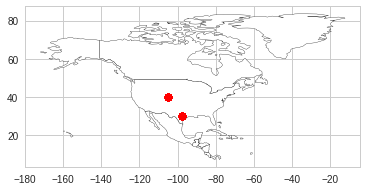

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to North America.
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='red')

plt.show()

In [0]:
gdf.longitude.nunique()

2

### Create a new cloumn called 'state' based on the Coordinates

In [0]:
weather.loc[weather['Coordinates'] == (-97.699662, 30.292432) , 'state'] = 'Texas'
weather.loc[weather['Coordinates'] == (-105.256111, 40.027278), 'state'] = 'Colorado'

In [0]:
weather.state.value_counts()

Colorado    8854
Texas       8829
Name: state, dtype: int64

In [0]:
weather['temperature'] = (weather['temperature']-32)/1.8

In [0]:
weather.head()

localhour  latitude  longitude  temperature  humidity  \
0  2017-01-01 00:00:00-06   30.2924   -97.6997      19.2000    0.7200   
1  2017-01-01 01:00:00-06   30.2924   -97.6997      17.5167    0.8300   
2  2017-01-01 02:00:00-06   30.2924   -97.6997      16.4056    0.8700   
3  2017-01-01 03:00:00-06   30.2924   -97.6997      15.7611    0.9200   
4  2017-01-01 04:00:00-06   30.2924   -97.6997      15.0778    0.9400   

   wind_speed              Coordinates  state  
0      4.0000  (-97.699662, 30.292432)  Texas  
1      4.9300  (-97.699662, 30.292432)  Texas  
2      4.8800  (-97.699662, 30.292432)  Texas  
3      4.4400  (-97.699662, 30.292432)  Texas  
4      4.5400  (-97.699662, 30.292432)  Texas

### Change weather.localhour from object to datetime 

In [0]:
weather['localhour'] = pd.to_datetime(weather['localhour'])
weather.localhour

0       2017-01-01 06:00:00
1       2017-01-01 07:00:00
2       2017-01-01 08:00:00
3       2017-01-01 09:00:00
4       2017-01-01 10:00:00
5       2017-01-01 11:00:00
6       2017-01-01 12:00:00
7       2017-01-01 13:00:00
8       2017-01-01 14:00:00
9       2017-01-01 15:00:00
10      2017-01-01 16:00:00
11      2017-01-01 17:00:00
12      2017-01-01 18:00:00
13      2017-01-01 19:00:00
14      2017-01-01 20:00:00
15      2017-01-01 21:00:00
16      2017-01-01 22:00:00
17      2017-01-01 23:00:00
18      2017-01-02 00:00:00
19      2017-01-02 01:00:00
20      2017-01-02 02:00:00
21      2017-01-02 03:00:00
22      2017-01-02 04:00:00
23      2017-01-02 05:00:00
24      2017-01-02 06:00:00
25      2017-01-02 07:00:00
26      2017-01-02 08:00:00
27      2017-01-02 09:00:00
28      2017-01-02 10:00:00
29      2017-01-02 11:00:00
                ...        
24717   2017-11-28 00:00:00
24718   2017-11-28 01:00:00
24719   2017-11-28 02:00:00
24720   2017-11-28 03:00:00
24721   2017-11-28 0

### Create a new column called 'ssd' （Human Comfort)

In [0]:
def ssd(row):
   return float((1.818 * row['temperature']+ 18.18)*(0.88 + 0.002 * row['humidity'])+(row['temperature']- 32) / (45 - row['temperature'])- 3.2 * row['wind_speed'] + 18.2)
  
weather['ssd'] = weather.apply (lambda row: ssd(row), axis=1)
weather.head(5)

latitude  longitude  temperature  humidity  wind_speed  \
localhour                                                                     
2017-01-01 06:00:00   30.2924   -97.6997      19.2000    0.7200      4.0000   
2017-01-01 07:00:00   30.2924   -97.6997      17.5167    0.8300      4.9300   
2017-01-01 08:00:00   30.2924   -97.6997      16.4056    0.8700      4.8800   
2017-01-01 09:00:00   30.2924   -97.6997      15.7611    0.9200      4.4400   
2017-01-01 10:00:00   30.2924   -97.6997      15.0778    0.9400      4.5400   

                                 Coordinates  state     ssd  
localhour                                                    
2017-01-01 06:00:00  (-97.699662, 30.292432)  Texas 51.6956  
2017-01-01 07:00:00  (-97.699662, 30.292432)  Texas 46.0023  
2017-01-01 08:00:00  (-97.699662, 30.292432)  Texas 44.3668  
2017-01-01 09:00:00  (-97.699662, 30.292432)  Texas 44.7364  
2017-01-01 10:00:00  (-97.699662, 30.292432)  Texas 43.3126

### Calculate the daily average temperature

In [0]:
weather.set_index('localhour', inplace=True)
weather_Texas = weather[weather['state'] == 'Texas']
weather_Colorado = weather[weather['state'] == 'Colorado']

In [0]:
daily_weather_Texas = pd.DataFrame()
daily_weather_Texas['ssd'] = weather_Texas['ssd'].resample('D').mean()
daily_weather_Texas['state'] = 'Texas'
daily_weather_Texas.head(20)

ssd  state
localhour                
2017-01-01 43.9108  Texas
2017-01-02 40.2390  Texas
2017-01-03 40.8041  Texas
2017-01-04 17.8573  Texas
2017-01-05 29.5382  Texas
2017-01-06 -6.8677  Texas
2017-01-07 -9.5941  Texas
2017-01-08 19.6015  Texas
2017-01-09 24.9293  Texas
2017-01-10 20.5600  Texas
2017-01-11 33.4624  Texas
2017-01-12 28.7525  Texas
2017-01-13 41.5302  Texas
2017-01-14 34.4364  Texas
2017-01-15 32.1141  Texas
2017-01-16 40.6218  Texas
2017-01-17 34.4294  Texas
2017-01-18 22.2709  Texas
2017-01-19 36.9348  Texas
2017-01-20 35.1347  Texas

In [0]:
daily_weather_Colorado = pd.DataFrame()
daily_weather_Colorado['ssd'] = weather_Colorado['ssd'].resample('D').mean()
daily_weather_Colorado['state'] = 'Colorado'
daily_weather_Colorado.head(20)

ssd     state
localhour                   
2017-01-01 24.3115  Colorado
2017-01-02 21.5850  Colorado
2017-01-03 14.6962  Colorado
2017-01-04 10.5928  Colorado
2017-01-05 -3.3870  Colorado
2017-01-06 -2.4982  Colorado
2017-01-07  3.1841  Colorado
2017-01-08 10.4532  Colorado
2017-01-09  8.5668  Colorado
2017-01-10 -3.9905  Colorado
2017-01-11 -7.8017  Colorado
2017-01-12 11.2057  Colorado
2017-01-13 12.9176  Colorado
2017-01-14 22.8325  Colorado
2017-01-15 25.3556  Colorado
2017-01-16 20.2504  Colorado
2017-01-17 22.1930  Colorado
2017-01-18 23.2956  Colorado
2017-01-19 28.9495  Colorado
2017-01-20 31.4538  Colorado

### Concatenate 'daily_weather_Texas' and 'daily_weather_Colorado'

In [0]:
weather_new = pd.concat([daily_weather_Texas, daily_weather_Colorado])

In [0]:
weather_new.reset_index(inplace= True)

In [0]:
weather_new = weather_new['ssd']
weather_new

localhour
2017-01-01   43.9108
2017-01-02   40.2390
2017-01-03   40.8041
2017-01-04   17.8573
2017-01-05   29.5382
2017-01-06   -6.8677
2017-01-07   -9.5941
2017-01-08   19.6015
2017-01-09   24.9293
2017-01-10   20.5600
2017-01-11   33.4624
2017-01-12   28.7525
2017-01-13   41.5302
2017-01-14   34.4364
2017-01-15   32.1141
2017-01-16   40.6218
2017-01-17   34.4294
2017-01-18   22.2709
2017-01-19   36.9348
2017-01-20   35.1347
2017-01-21   47.8029
2017-01-22   17.3117
2017-01-23   25.3952
2017-01-24   36.0049
2017-01-25   35.6319
2017-01-26   23.8728
2017-01-27   27.5232
2017-01-28   23.9907
2017-01-29   23.9508
2017-01-30   32.9377
               ...  
2017-12-02   41.3405
2017-12-03   41.2340
2017-12-04   23.7005
2017-12-05   27.0254
2017-12-06   25.4760
2017-12-07   21.9282
2017-12-08   35.5326
2017-12-09   39.7717
2017-12-10   38.8266
2017-12-11   39.4478
2017-12-12   39.1945
2017-12-13   38.1299
2017-12-14   31.7364
2017-12-15   30.2218
2017-12-16   40.4911
2017-12-17   30.9778
201

### Export 'weather' dataset

In [0]:
from google.colab import drive
drive.mount('drive')

weather_new.to_csv('weather_new.csv')
!cp weather_new.csv drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


## Merge 'final' and 'weather' datasets (new feature 'ssd')

In [0]:
final = importfile(file_id = '1-1uSVok5sd2IB8JrOLV68AFNDHe_tzCs')
final = pd.read_csv(os.path.join("/content","final.csv"), header = 0, keep_default_na = False)
final.head()

Drive file (title: final.csv, id: 1-1uSVok5sd2IB8JrOLV68AFNDHe_tzCs)
file path: /content/final.csv


Unnamed: 0  dataid            localhour       car1  state  label  \
0           0     410  2017-01-29 11:00:00  unknown_1  Texas      1   
1           1     410  2017-04-20 13:00:00  unknown_1  Texas      1   
2           2     410  2017-05-07 12:00:00  unknown_1  Texas      1   
3           3     410  2017-05-07 13:00:00  unknown_1  Texas      1   
4           4     410  2017-05-10 11:00:00  unknown_1  Texas      1   

   vehicle_type_Chevrolet Volt  vehicle_type_Mitsubishi i-MiEV  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   vehicle_type_Nissan Leaf  vehicle_type_Tesla Model S  ...    \
0                         1                           0  ...     
1                         1                           0  ...     
2                         1                           0  ...     
3                         1                           0  ...     
4                         1                           0  ...     

   electric_vehicle_buy_again_unknown_1  city_Austin  city_Boulder  \
0                                     0            1             0   
1                                     0            1             0   
2                                     0            1             0   
3                                     0            1             0   
4                                     0            1             0   

   city_Coppell  city_Dallas  city_Houston  city_Humble  city_Plano  \
0             0            0             0            0           0   
1             0            0             0            0           0   
2             0            0             0            0           0   
3             0            0             0            0           0   
4             0            0             0            0           0   

   city_Round Rock    use  
0                0 0.1904  
1                0 0.4522  
2                0 0.1344  
3                0 0.1437  
4                0 0.2219  

[5 rows x 156 columns]

In [0]:
weather_new['localhour'] = pd.to_datetime(weather_new['localhour'])
final['localhour'] = pd.to_datetime(final['localhour'])

In [0]:
final_ssd = pd.merge(final,
                 weather_new[['localhour', 'state', 'ssd']],
                 on=['localhour','state'],
                 how = 'left')
final_ssd.ssd = pd.to_numeric(final_ssd.ssd, errors="coerce")
final_ssd.head()

Unnamed: 0  dataid           localhour       car1  state  label  \
0           0     410 2017-01-29 11:00:00  unknown_1  Texas      1   
1           1     410 2017-04-20 13:00:00  unknown_1  Texas      1   
2           2     410 2017-05-07 12:00:00  unknown_1  Texas      1   
3           3     410 2017-05-07 13:00:00  unknown_1  Texas      1   
4           4     410 2017-05-10 11:00:00  unknown_1  Texas      1   

   vehicle_type_Chevrolet Volt  vehicle_type_Mitsubishi i-MiEV  \
0                            0                               0   
1                            0                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   vehicle_type_Nissan Leaf  vehicle_type_Tesla Model S ...   city_Austin  \
0                         1                           0 ...             1   
1                         1                           0 ...             1   
2                         1                           0 ...             1   
3                         1                           0 ...             1   
4                         1                           0 ...             1   

   city_Boulder  city_Coppell  city_Dallas  city_Houston  city_Humble  \
0             0             0            0             0            0   
1             0             0            0             0            0   
2             0             0            0             0            0   
3             0             0            0             0            0   
4             0             0            0             0            0   

   city_Plano  city_Round Rock    use  ssd  
0           0                0 0.1904  nan  
1           0                0 0.4522  nan  
2           0                0 0.1344  nan  
3           0                0 0.1437  nan  
4           0                0 0.2219  nan  

[5 rows x 157 columns]

In [0]:
final_ssd.isnull().sum(axis=0).sort_values(ascending=False)/float(len(final_ssd))

ssd                                                           0.9581
spend_time_at_home_wednesday_unknown_0                        0.0000
spend_time_at_home_friday_unknown_1                           0.0000
spend_time_at_home_friday_unknown_0                           0.0000
spend_time_at_home_friday_Friday                              0.0000
spend_time_at_home_thursday_unknown_1                         0.0000
spend_time_at_home_thursday_unknown_0                         0.0000
spend_time_at_home_thursday_Thursday                          0.0000
spend_time_at_home_wednesday_unknown_1                        0.0000
spend_time_at_home_wednesday_Wednesday                        0.0000
ethnicity_caucasian_other_than_hispanic_or_latino_unknown_0   0.0000
spend_time_at_home_tuesday_unknown_1                          0.0000
spend_time_at_home_tuesday_unknown_0                          0.0000
spend_time_at_home_tuesday_Tuesday                            0.0000
spend_time_at_home_monday_unknown_

In [0]:
final_ssd.ssd = final_ssd.ssd.fillna(0)
final_ssd.drop(['Unnamed: 0'], axis = 1, inplace= True)
final_ssd.isnull().sum(axis=0).sort_values(ascending=False)/float(len(final_ssd))

ssd                                                           0.0000
spend_time_at_home_wednesday_unknown_1                        0.0000
ethnicity_caucasian_other_than_hispanic_or_latino_Caucasian   0.0000
spend_time_at_home_friday_unknown_1                           0.0000
spend_time_at_home_friday_unknown_0                           0.0000
spend_time_at_home_friday_Friday                              0.0000
spend_time_at_home_thursday_unknown_1                         0.0000
spend_time_at_home_thursday_unknown_0                         0.0000
spend_time_at_home_thursday_Thursday                          0.0000
spend_time_at_home_wednesday_unknown_0                        0.0000
ethnicity_caucasian_other_than_hispanic_or_latino_unknown_1   0.0000
spend_time_at_home_wednesday_Wednesday                        0.0000
spend_time_at_home_tuesday_unknown_1                          0.0000
spend_time_at_home_tuesday_unknown_0                          0.0000
spend_time_at_home_tuesday_Tuesday

In [0]:
final_ssd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673200 entries, 0 to 673199
Columns: 156 entries, dataid to ssd
dtypes: datetime64[ns](1), float64(2), int64(151), object(2)
memory usage: 826.4+ MB


### One-hot encoding with the feature 'state'

In [0]:
final_ssd = pd.concat([final_ssd,pd.get_dummies(final_ssd['state'], prefix='state')],axis=1)
final_ssd.drop(['state'],axis=1, inplace=True)
final_ssd.head(5)

dataid           localhour       car1  label  vehicle_type_Chevrolet Volt  \
0     410 2017-01-29 11:00:00  unknown_1      1                            0   
1     410 2017-04-20 13:00:00  unknown_1      1                            0   
2     410 2017-05-07 12:00:00  unknown_1      1                            0   
3     410 2017-05-07 13:00:00  unknown_1      1                            0   
4     410 2017-05-10 11:00:00  unknown_1      1                            0   

   vehicle_type_Mitsubishi i-MiEV  vehicle_type_Nissan Leaf  \
0                               0                         1   
1                               0                         1   
2                               0                         1   
3                               0                         1   
4                               0                         1   

   vehicle_type_Tesla Model S  vehicle_type_unknown_0  vehicle_type_unknown_1  \
0                           0                       0                       0   
1                           0                       0                       0   
2                           0                       0                       0   
3                           0                       0                       0   
4                           0                       0                       0   

      ...       city_Coppell  city_Dallas  city_Houston  city_Humble  \
0     ...                  0            0             0            0   
1     ...                  0            0             0            0   
2     ...                  0            0             0            0   
3     ...                  0            0             0            0   
4     ...                  0            0             0            0   

   city_Plano  city_Round Rock    use     ssd  state_Colorado  state_Texas  
0           0                0 0.1904 27.5180               0            1  
1           0                0 0.4522 40.8545               0            1  
2           0                0 0.1344 51.8567               0            1  
3           0                0 0.1437 50.4463               0            1  
4           0                0 0.2219 37.8693               0            1  

[5 rows x 157 columns]

## Mount 'final_ssd' to the google drive

In [0]:
final_ssd.to_csv('final_ssd.csv')
!cp final_ssd.csv drive/My\ Drive/